# Denoising Auto Encoder on MNIST data
given a noisy samples we try to generate the same samples without noise

In [9]:
import numpy as np
import imageio
import torch
import torch.nn as nn
from torch.nn import Sequential
from torch.nn import Linear,ReLU,Sigmoid,Dropout,Tanh
from torch.nn import MSELoss,BCELoss
from torch import optim
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
transform = transforms.Compose([        
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
])
data = MNIST(root="./mnist_data",train=True,download=True,transform=transform)
trainloader = DataLoader(data,batch_size=64,shuffle=True)

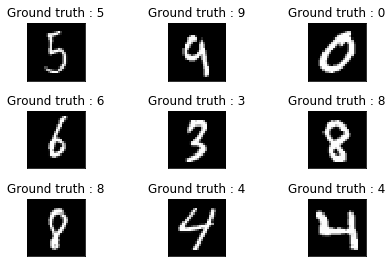

In [12]:
samples = enumerate(trainloader)
b_idx,(inp,targ) = next(samples)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(inp[i][0],cmap="gray",interpolation="none")
    plt.title("Ground truth : {}".format(targ[i]))
    plt.xticks([])
    plt.yticks([])

##### Implementing vanilla model 

In [13]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        self.encoder = Sequential(
            Linear(784,256),
            ReLU(True),
            Dropout(0.2),
            Linear(256,64),
            ReLU(True)
        )
        self.decoder = Sequential(
            # hidden state vector will be 64 size one
            Linear(64,256),
            ReLU(True),
            Dropout(0.2),
            Linear(256,784),
            Sigmoid()
        )
        
    def forward(self,x): 
        #x = x.view(-1,784)
        z = self.encoder(x)
        output = self.decoder(z)
        #output = output.view(-1,1,28,28)
        return output

In [14]:
aue = autoencoder()
aue.to(device)
aue_optim = optim.Adam(aue.parameters(),lr=0.01,weight_decay=1e-5)
criterion = MSELoss()
images = []

def add_noise(tensor,mean=0., std=1.):
    return tensor + torch.randn(tensor.size()) * std + mean

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    curr_loss=0.0
    for i,(inp,_) in enumerate(trainloader):
        aue_inp = inp.view(-1,784)
        noisy_img = add_noise(aue_inp).to(device)
        denoise_img = aue(noisy_img)
        aue_inp =  Variable(aue_inp).to(device)
        aue_loss = criterion(denoise_img,aue_inp)
        aue_loss.backward()
        aue_optim.zero_grad()
        aue_optim.step()
        curr_loss+=aue_loss
    
    print("loss in epoch: {}/{} is {.5f}".format(epoch,num_epochs,aue_loss.data))
    '''
        if epoch%2==0:
            x_input_img = transforms.ToPILImage()(make_grid(aue_input.cpu().data))
            x_noise_img = transforms.ToPILImage()(make_grid(noisy_img.cpu().data))
            x_output_img = transforms.ToPILImage()(make_grid(denoise_img.cpu().data))
            plt.imshow(x_input_img)
            plt.imshow(x_noise_img)
            plt.imshow(x_output_img)
    '''

torch.save(aue.state_dict(),'dae.pt')

loss in epoch: 0/100 is 1.9114246368408203
loss in epoch: 1/100 is 1.927992820739746
loss in epoch: 2/100 is 1.9201161861419678
loss in epoch: 3/100 is 1.906660556793213
loss in epoch: 4/100 is 1.9435091018676758
loss in epoch: 5/100 is 1.9294791221618652
loss in epoch: 6/100 is 1.9047669172286987
loss in epoch: 7/100 is 1.9338126182556152
loss in epoch: 8/100 is 1.9031211137771606
loss in epoch: 9/100 is 1.858297348022461
loss in epoch: 10/100 is 1.946396827697754
